# Label pipeline
In this notebook, we try out the entire pipeline - from D + semantic data, through building a semantic map,
to raytracing the labels back to the camera position

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import open3d as o3d

from src.features.mapping import SemanticMap3DBuilder
from src.config import default_map_builder_cfg, default_sim_cfg
from src.utils import category_mapping
from src.utils.misc import get_semantic_map, semantic_map_to_categorical_map
import pathlib
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if pathlib.PurePath(os.getcwd()).name == 'notebooks':
    print(pathlib.PurePath(os.getcwd()).name)
    os.chdir('..')

notebooks


In [3]:
TRAJECTORY = "00006-HkseAnWCgqk"
DEPTH_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/D"
RGB_IMAGE_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/RGB"
POSITIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/positions.npy"
ROTATIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/rotations.npy"
SEMANTIC_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/Semantic"
trajectory_name = TRAJECTORY.split('-')[1]
SEMANTIC_INFO_FILE = f"./data/raw/train/scene_datasets/hm3d/train/{TRAJECTORY}/{trajectory_name}.semantic.txt"

In [4]:
scene_to_reseal_mapping = category_mapping.get_scene_index_to_reseal_index_map_vectorized(SEMANTIC_INFO_FILE)

Create map builder

In [28]:
sim_cfg = default_sim_cfg()
map_builder_cfg = default_map_builder_cfg()
map_builder_cfg.NUM_SEMANTIC_CLASSES = 6
map_builder_cfg.RESOLUTION = 0.05
map_builder_cfg.MAP_SIZE = [4,2,4]
map_builder = SemanticMap3DBuilder(map_builder_cfg, sim_cfg)


[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


Load poses, rgb images and depth images. Create semantic map, with RGB images as a placeholder for semantic labels

In [29]:
rotations = np.load(ROTATIONS_FILE).view(dtype=np.quaternion)
positions = np.load(POSITIONS_FILE)
scene_index_to_category_index_map = category_mapping.get_scene_index_to_reseal_index_map_vectorized(SEMANTIC_INFO_FILE)

map_builder.clear()
for i in tqdm(range(400)):
    depth_map = np.load(f"{DEPTH_MAP_DIR}/{i}.npy")
    saved_semantics = np.load(f"{SEMANTIC_MAP_DIR}/{i}.npy")
    semantic_map = get_semantic_map(saved_semantics, scene_index_to_category_index_map, 
                                    map_builder_cfg.NUM_SEMANTIC_CLASSES)
    pose = (positions[i], rotations[i])
    map_builder.update_point_cloud(semantic_map, depth_map, pose, fast=True)
map_builder.concatenate_semantics()
print("Concatenating semantics done")
map_builder.update_kdtree()

100%|██████████| 400/400 [00:03<00:00, 119.14it/s]


Concatenating semantics done


In [31]:
point_cloud = np.asarray(map_builder.point_cloud.points)
point_cloud_semantic_labels = map_builder._point_cloud_semantic_labels

Get point cloud and visualize points with semantic information

In [32]:
color_converter = category_mapping.get_reseal_color_converter()

point_cloud_categorical = (np.argmax(point_cloud_semantic_labels, axis=-1) + 
                           np.sum(point_cloud_semantic_labels, axis=-1))
# Need to initialize this as a 3 channel image so we can use numpy indexing to assign the points that have a label
# instead of having to loop over them
point_cloud_rgb = np.dstack([point_cloud_categorical]*3)[0]
point_cloud_rgb[point_cloud_categorical > 0] = color_converter(point_cloud_categorical[point_cloud_categorical > 0])

In [33]:
point_cloud_o3d = o3d.utility.Vector3dVector(point_cloud[point_cloud_categorical > 0])
pcd = o3d.geometry.PointCloud(point_cloud_o3d)
colour = point_cloud_rgb[point_cloud_categorical > 0]
pcd.colors = o3d.utility.Vector3dVector(colour)
o3d.visualization.draw_geometries([pcd])

Get 3D semantic map (i.e. Voxel grid) at an index and plot it

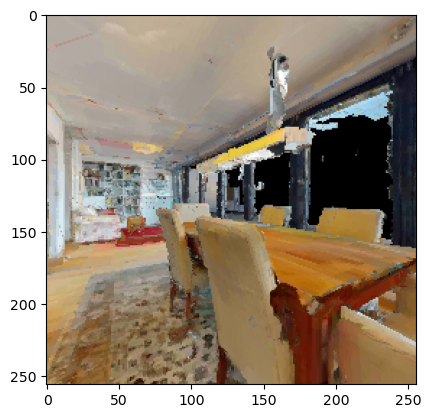

In [34]:
index = 322

rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{index}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255
plt.imshow(rgb_image)

In [38]:
map_at_index = map_builder.get_semantic_map((positions[index],0))

In [36]:
map_at_index_sparse = map_builder.get_semantic_map_sparse((positions[index],0), use_dicts=False)

In [22]:
# Clear all voxels with no semantic information
uninteresting_voxels = map_at_index_sparse[:,:,:,1:].sum(axis=-1) == 0
grid_for_plotting = map_at_index_sparse.copy()
grid_for_plotting[uninteresting_voxels,:]=0

reseal_category = semantic_map_to_categorical_map(grid_for_plotting)
colour = color_converter(reseal_category)

[149.  19. 149.]


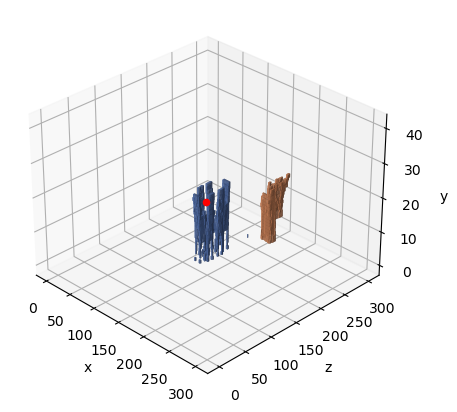

In [23]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

grid_T = np.transpose(grid_for_plotting, (0,2,1,3))
colour_T = np.transpose(colour, (0,2,1,3))


# Plot 3d voxel grid
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111, projection='3d')
agent_position = map_builder._map_size/2//map_builder._resolution
print(agent_position)
ax1.scatter(agent_position[0], agent_position[2], agent_position[1], c='r', marker='o')
ax1.voxels(grid_T[:,:,:,0], facecolors=colour_T)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_zlabel('y')
ax1.view_init(azim=-45)
plt.show()


Raytrace

In [43]:
from src.features.perception import propagate_labels
from src.utils.geometric_transformations import coordinates_to_grid_indices

sensor_position = positions[index]
sensor_rotation = rotations[index]

min_position, _ = map_builder.get_semantic_map_bounds(positions[index])
grid_index_of_min_position_relative_to_origin = coordinates_to_grid_indices(np.array(min_position), [0,0,0], map_builder._resolution)
grid_index_of_origin = - grid_index_of_min_position_relative_to_origin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


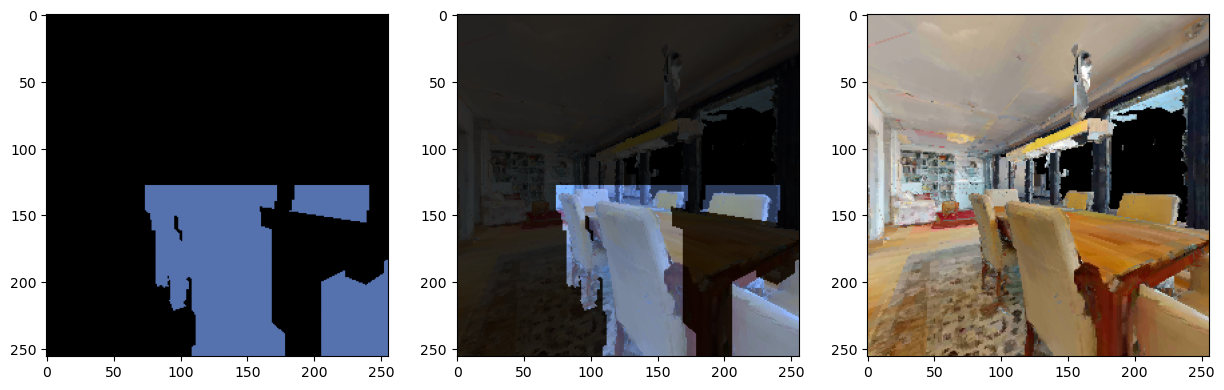

In [46]:
semantic_map_2d = propagate_labels(sensor_rotation, sensor_position, map_at_index_sparse, grid_index_of_origin, 
                                   map_builder_cfg, sim_cfg.SENSOR_CFG)

semantic_map_categorical = (np.argmax(semantic_map_2d, axis=-1) + 
                            np.sum(semantic_map_2d, axis=-1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axs
ax1.imshow(color_converter(semantic_map_categorical))

ax2.imshow(rgb_image*0.2 + (rgb_image+0.5)*(color_converter(semantic_map_categorical)))

ax3.imshow(rgb_image)
plt.show()